In [1]:
import riskfolio as rp 
import pandas as pd
import numpy as np
from openbb_terminal.sdk import openbb
import datetime
from dateutil.relativedelta import relativedelta
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import get_as_dataframe
import yfinance as yf
import bt 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/spreadsheets','https://www.googleapis.com/auth/drive.file','https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name('/Users/adamjohnson/Documents/GoogleCloudService/gspread-api-394113-fcd586f615d5.json', scope)

client = gspread.authorize(credentials)

#sheet =client.open('Risk Parity Database')

sheet =client.open_by_key('1_XjLk6Vrz7ht5twTK_jARrNf8pBkgVztr8ft5o8ADow')

sheet_instance = sheet.get_worksheet(0)

data = sheet_instance.get_all_values()

portfolio = pd.DataFrame(data)

headers = portfolio.iloc[0]
portfolio = pd.DataFrame(portfolio.values[1:], columns=headers)

portfolio.set_index('Ticker', inplace=True)

portfolio = portfolio[['% Allocation','CVaR']]

portfolio['CVaR'] = portfolio['CVaR'].astype(float)
portfolio['% Allocation'] = portfolio['% Allocation'].astype(float)

portfolio 

,% Allocation,CVaR
Ticker,,
CEG,0.11,0.077
AAPL,0.09,0.071
RTX,0.08,0.068
PANW,0.06,0.048
NOW,0.04,0.038
AMZN,0.06,0.050
CVX,0.07,0.062
JPM,0.07,0.065
MSFT,0.09,0.086


In [7]:
end = pd.Timestamp(datetime.date.today())
#start = end - relativedelta(years=1)
start = '2023-11-16'

symbols = portfolio.index.tolist()

#stock_data = yf.download(symbols, start= start, end= end)['Adj Close']

stock_data = openbb.stocks.ca.hist(symbols,start, end)

stock_data.dropna(how="any", axis=1, inplace=True)

port_CVaR = portfolio['CVaR'].tolist()

# Fetch the S&P 500 index data
sp500_data = yf.download('^GSPC', start= start, end= end)['Adj Close']

sp500_data = sp500_data.to_frame(name='S&P500')

[*********************100%***********************]  1 of 1 completed


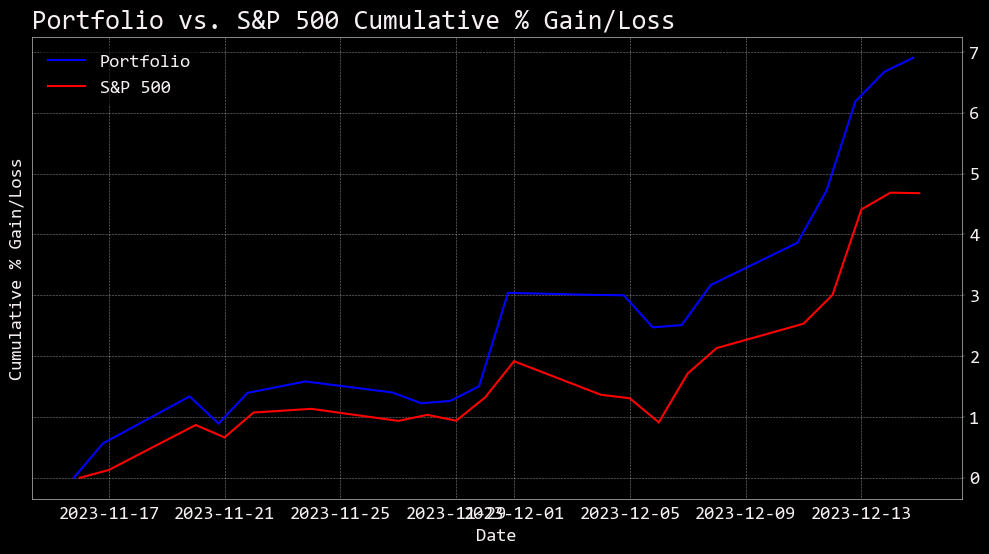

Date
2023-11-16    0.000000
2023-11-17    0.563997
2023-11-20    1.338125
2023-11-21    0.891718
2023-11-22    1.396166
2023-11-24    1.583921
2023-11-27    1.402905
2023-11-28    1.225881
2023-11-29    1.262598
2023-11-30    1.504662
2023-12-01    3.040108
2023-12-04    3.006345
2023-12-05    3.000953
2023-12-06    2.472964
2023-12-07    2.510484
2023-12-08    3.167893
2023-12-11    3.864422
2023-12-12    4.717501
2023-12-13    6.186655
2023-12-14    6.674191
2023-12-15    6.904242
dtype: float64
                             S&P500
Date                               
2023-11-16 00:00:00-05:00  0.000000
2023-11-17 00:00:00-05:00  0.128205
2023-11-20 00:00:00-05:00  0.868180
2023-11-21 00:00:00-05:00  0.664333
2023-11-22 00:00:00-05:00  1.073143
2023-11-24 00:00:00-05:00  1.133471
2023-11-27 00:00:00-05:00  0.935841
2023-11-28 00:00:00-05:00  1.034770
2023-11-29 00:00:00-05:00  0.939166
2023-11-30 00:00:00-05:00  1.321127
2023-12-01 00:00:00-05:00  1.916261
2023-12-04 00:00:00-05:00  1.

In [8]:
# Calculate daily portfolio value
portfolio_value = (stock_data / stock_data.iloc[0] * portfolio['CVaR'].values).sum(axis=1)

# Calculate cumulative daily percentage gain/loss
cumulative_returns = (portfolio_value / portfolio_value.iloc[0] - 1) * 100
cumulative_sp500_returns = (sp500_data / sp500_data.iloc[0] - 1) * 100

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns, label='Portfolio', color='blue')
plt.plot(cumulative_sp500_returns.index, cumulative_sp500_returns, label='S&P 500', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative % Gain/Loss')
plt.title('Portfolio vs. S&P 500 Cumulative % Gain/Loss')
plt.legend()
plt.grid(True)
plt.show()

print(cumulative_returns)
print(cumulative_sp500_returns)